For this project, you will interpret data from the National Parks Service about endangered species in different parks.

You will perform some data analysis on the conservation statuses of these species and investigate if there are any patterns or themes to the types of species that become endangered. During this project, you will analyze, clean up, and plot data as well as pose questions and seek to answer them in a meaningful way.

After you perform your analysis, you will share your findings about the National Park Service.

Scoping Project

1) Import and review data for project
2) Analyze the data and begin to develop questions
3) Conduct analysis to answer the questions posed above
4) Summarize the findings of your answers to these questions

In [86]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [107]:
# ingest raw data
obs_df = pd.read_csv('observations.csv', skipinitialspace=True)
spec_df = pd.read_csv('species_info.csv', skipinitialspace=True)

# clean up data frames

''' We see multiple recorded observations for one location and species type (ex: Echinochloa crus-galli @ 
Bryce has obs of 112 and 116). To err on the side of caution, this report is going to be considering the 
lowest of all of the values for specific species/ location combinations (e.g: 112 from the above example.)'''

# sort by the number of observations (smaller first), then keep smallest of duplicates
obs_df = obs_df.sort_values('observations', ascending=True).drop_duplicates(['scientific_name', 'park_name'], keep= 'first').sort_index() # from https://stackoverflow.com/questions/12497402/remove-duplicates-by-columns-a-keeping-the-row-with-the-highest-value-in-column/68876659#68876659


''' We also see multiple duplicates in the species information. Upon review, we have multiple common names 
and conservation statuses for a single species (ex: Canis lupus is both endangered and in recovery). In a 
similar approch, this analysis will bias towards caution -- marking a species as Endangered rather than 
In Recovery when there is a conflict. All common names have been combined to keep their values intact.'''

# combine all common names for each scientific name
spec_names = spec_df.groupby(['scientific_name'])['common_names'].apply(', '.join).reset_index() # from https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby

# assign all common names back to species data frame
spec_df = pd.merge(spec_df, spec_names, on= 'scientific_name', how= 'left')

# drop old common names column
spec_df = spec_df.drop(columns= 'common_names_x')

# rename new common names column
spec_df.rename(columns= {'common_names_y': 'common_names'}, errors="raise", inplace= True)

# remove redundant names from common names column
spec_df['common_names'] = spec_df['common_names'].str.replace(' ,', ',')
spec_df['common_names'] = spec_df['common_names'].str.replace(', ', ',')
spec_df['common_names']=spec_df['common_names'].str.split(',').apply(lambda x : ', '.join(set(x)))

# encode data to enable sorting by conservation status for duplicates (Endangered > Threatened > Species of Concern > In Recovery > None)
spec_df['conservation_status'] = spec_df['conservation_status'].replace(np.nan, 'None')
spec_df['conservation_group'] = pd.Categorical(spec_df['conservation_status'], ordered=True, categories=['None', 'In Recovery', 'Species of Concern', 'Threatened', 'Endangered'])

# drop duplicate species keeping the most conservative level in conservation group
spec_df = spec_df.sort_values('conservation_group', ascending=True).drop_duplicates(['scientific_name'], keep= 'last')

# drop column used for sorting
spec_df = spec_df.drop('conservation_group', 1)
spec_df.to_csv('spec_df.csv')

# combine all data into single data frame
bio_df = pd.merge(spec_df, obs_df, on= 'scientific_name', how= 'left')

# confirm merge using original csvs # confirmed
# bio_df[bio_df['conservation_status'] == 'Endangered'].head(10)

bio_df.head()
bio_df.to_csv('bio_df.csv')

#### Data

I should describe the errata in the data more.

After cleaning the data, there are 22,164 observations with 5,541 scientific names (5,236 lists of common names). Observations of these species span 7 categories, 5 conservation statuses, and 4 parks. The bulk of the species (96.8%) are in no conservation group (meaning they are not a in recovery, a species of concern, threatened, or endangered). Of those which are in a group (do have a conservation status); 12 (0.1%) are in recovery, 604 (2.7%) are species of concern, 40 (0.2%) are threatened, and 60 (0.3%) are endangered.

The most common category was vascular plants at 76.9% of the species, followed by birds at 8.8%. Nonvascular plants made up 6.0% of the species, with the remaining four categories (mammal, fish, amphibian, and reptile) constituting the remaining 8.3%.

The median number of all obeservations across all species and parks is 124, with a minimum of 9, and a maximum of 321.

# Charting

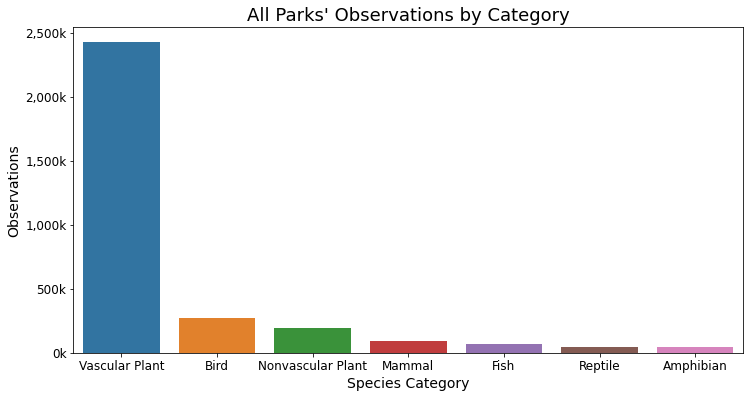

In [108]:
# sum observations by category
category_obs = bio_df.groupby('category')[['observations']].sum()

fig, ax = plt.subplots(figsize=(12, 6)) 
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(data= category_obs, x=category_obs.index, y= 'observations', 
            order=category_obs.sort_values('observations', ascending= False).index)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k'))
plt.title('All Parks\' Observations by Category',fontsize=18)
plt.xlabel('Species Category', fontsize=14)
plt.ylabel('Observations', fontsize=14)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

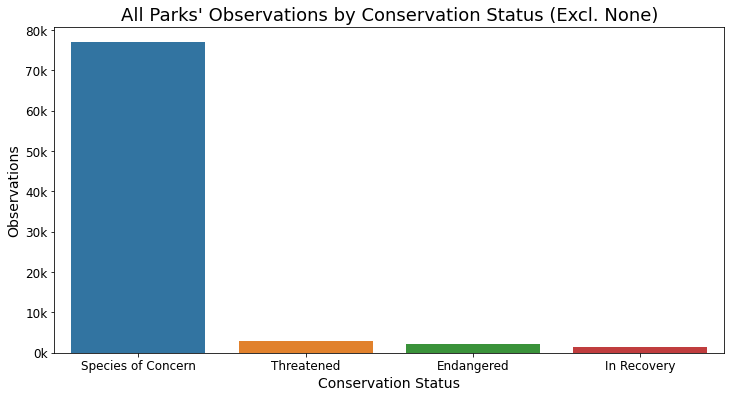

In [135]:
# sum observations by conservation status
status_obs = bio_df.loc[bio_df['conservation_status'] != 'None']
status_obs = status_obs.groupby('conservation_status')[['observations']].sum()
status_obs

fig, ax = plt.subplots(figsize=(12, 6)) 
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(data= status_obs, x=status_obs.index, y= 'observations', 
            order=status_obs.sort_values('observations', ascending= False).index)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k'))
plt.title('All Parks\' Observations by Conservation Status (Excl. None)',fontsize=18)
plt.xlabel('Conservation Status', fontsize=14)
plt.ylabel('Observations', fontsize=14)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

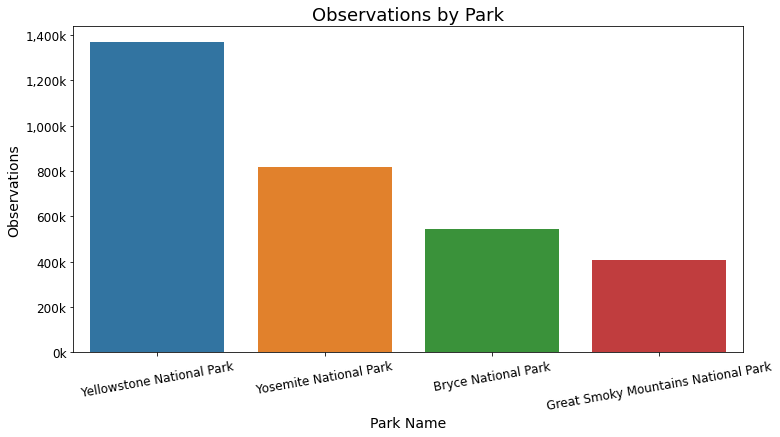

In [142]:
# sum observations by park
park_obs = bio_df.groupby('park_name')[['observations']].sum()

fig, ax = plt.subplots(figsize=(12, 6)) 
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(data= park_obs, x=park_obs.index, y= 'observations', 
            order= park_obs.sort_values('observations', ascending= False).index)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k'))
plt.title('Observations by Park',fontsize=18)
plt.xlabel('Park Name', fontsize=14)
plt.ylabel('Observations', fontsize=14)
plt.xticks(fontsize=12, rotation= 10);
plt.yticks(fontsize=12);

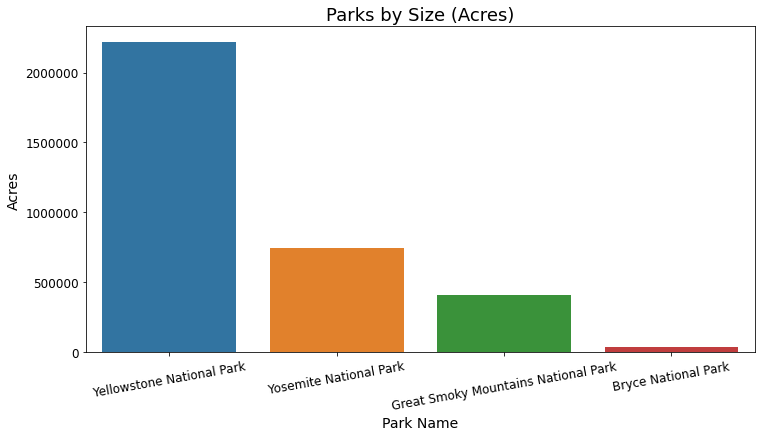

In [151]:
# create a df of the park acreage for 'diversity' plot
park_acres = {'acres': [35835, 407679, 2219791, 747956]}
park_labels = ['Bryce National Park', 'Great Smoky Mountains National Park', 'Yellowstone National Park', 'Yosemite National Park']
park_size = pd.DataFrame(park_acres, index= park_labels)
park_size.index.name = 'park_name'

fig, ax = plt.subplots(figsize= (12, 6)) 
plt.ticklabel_format(style= 'plain', axis= 'y')
sns.barplot(data= park_size, x= park_size.index, y= 'acres', 
            order= park_size.sort_values('acres', ascending= False).index)
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k'))
plt.title('Parks by Size (Acres)',fontsize=18)
plt.xlabel('Park Name', fontsize= 14)
plt.ylabel('Acres', fontsize= 14)
plt.xticks(fontsize= 12, rotation= 10);
plt.yticks(fontsize= 12);

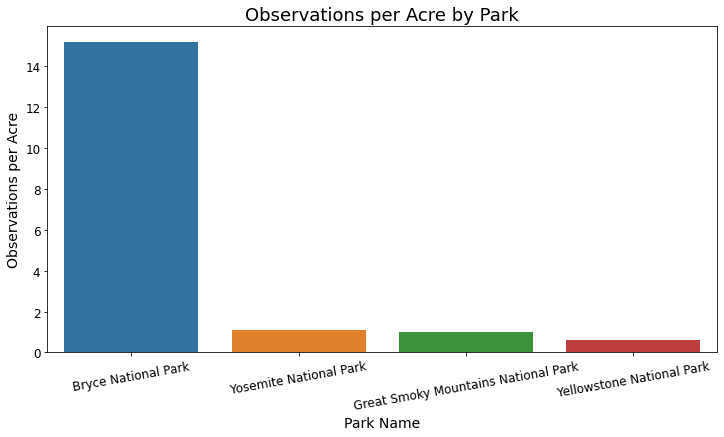

In [161]:
# plot observations per acre across parks
obs_per_acre = pd.merge(park_obs, park_size, left_index=True, right_index=True)
obs_per_acre['observations_per_acre'] = obs_per_acre['observations'] / obs_per_acre['acres']
obs_per_acre

fig, ax = plt.subplots(figsize= (12, 6)) 
plt.ticklabel_format(style= 'plain', axis= 'y')
sns.barplot(data= obs_per_acre, x= obs_per_acre.index, y= 'observations_per_acre', 
            order= obs_per_acre.sort_values('observations_per_acre', ascending= False).index)
plt.title('Observations per Acre by Park',fontsize=18)
plt.xlabel('Park Name', fontsize= 14)
plt.ylabel('Observations per Acre', fontsize= 14)
plt.xticks(fontsize= 12, rotation= 10);
plt.yticks(fontsize= 12);

In [79]:
# count species by category
# category_species_count = bio_df.groupby(['category'])[['scientific_name']].count()
# the above doesn't work as all species are accounted for in each park. in order to get the true number, we would have
# to divide the count by 4, or groupby on the spec_df dataset. the latter feels better than using a scalar.

category_species_count = spec_df.groupby('category')[['scientific_name']].count()
category_species_count

,scientific_name
category,
Amphibian,79
Bird,488
Fish,125
Mammal,176
Nonvascular Plant,333
Reptile,78
Vascular Plant,4262


In [80]:
# count species by status
status_species_count = spec_df.groupby('conservation_status')[['scientific_name']].count()
status_species_count

,scientific_name
conservation_status,
Endangered,15
In Recovery,3
None,5362
Species of Concern,151
Threatened,10


In [81]:
# count species by park # if my theory is correct, these should be the same
park_species_count = bio_df.groupby('park_name')[['scientific_name']].count()
park_species_count

# they are the same. the theory is correct.

,scientific_name
park_name,
Bryce National Park,5541
Great Smoky Mountains National Park,5541
Yellowstone National Park,5541
Yosemite National Park,5541


#### Plot the Count of Conservation Groups

# What are the best data viz techniques for cross sectional data?

In [82]:
# plot_df = spec_df[spec_df['conservation_status'] != 'None']

spec_df

# f, ax = plt.subplots(figsize=(15, 10))
# sns.countplot(data= plot_df, x= 'conservation_status', order = plot_df['conservation_status'].value_counts().index)
# plt.title('Count of Species in Conservation Status')

,category,scientific_name,conservation_status,common_names
0,Mammal,Clethrionomys gapperi gapperi,None,Gapper's Red-Backed Vole
3879,Vascular Plant,Apocynum cannabinum var. cannabinum,None,Indian Hemp
3876,Vascular Plant,Betula occidentalis,None,Water Birch
3875,Vascular Plant,Betula glandulosa,None,Resin Birch
3874,Vascular Plant,Polygala alba,None,White Milkwort
...,...,...,...,...
4601,Amphibian,Rana sierrae,Endangered,Sierra Nevada Yellow-Legged Frog
276,Bird,Vermivora bachmanii,Endangered,"Bachman's Wood Warbler, Bachman's Warbler"
2497,Vascular Plant,Geum radiatum,Endangered,"Spreading Avens, Mountain Avens"
9,Mammal,Canis rufus,Endangered,Red Wolf


#### Plot the Count of Categories

NameError: name 'plot_df' is not defined

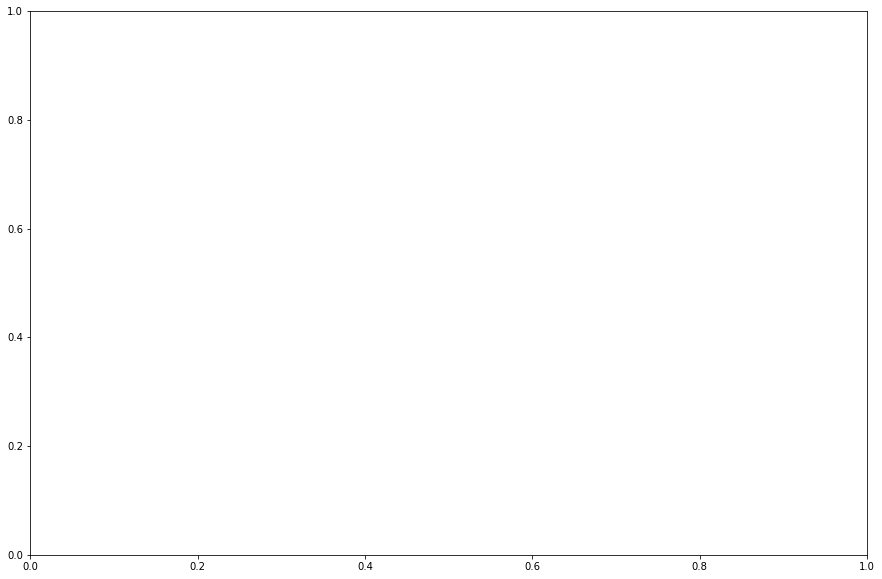

In [83]:
f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data= plot_df, x= 'category', order = 
      bio_df['category'].value_counts().index)

#### Plot Number of Observations of Each Conservation Group

#### Questions:

##### What is a 'good' (bad, great) amount of observations?
Maybe total and median amount of observations per category?

##### Do we see a relationship between the number of observations being low and troubled species?
Bar plots of the median number of observations by category by status

##### How we identify troubled species within a category using observations
One s.d. down from the median and below?

##### Which parks house the most troubled species, and in which category?
How do the species counts compare of conservation groups compare across parks

##### Which species are the most troubled , and in which park?
Which species seem to be the worst off based on species count and conservation status

##### Which category is most troubled?
Of the categories available, which are most threatened (as a percentage of their total population)?

##### Which species is most troubled?
Of all of the species that we see, which seem to be the most precarious?

### What is a 'good' amount of observations?

In [ ]:
# What is a 'good' (bad, great) amount of observations?
# Create a boxplot of observations on the x-axis, and categories on the y-axis

f, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(x= 'observations', y= 'category', data=bio_df, width=.6, palette= 'Spectral')
plt.title('Observations by Category')


In [ ]:
f, ax = plt.subplots(figsize=(12, 6))
bio_df_troubled = bio_df.loc[bio_df['conservation_group'] != 'None']
sns.boxplot(x= 'observations', y= 'conservation_group', data=bio_df_troubled, hue ='park_name', width=.6)
plt.title('Observations by Conservation Staus')